In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import os 
import sys 

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..','..','..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
from pipeline.plotting.TS_analysis import plot_TS
from jupyter_ipynb.NetMob_training_analysis.plotting import plot_boxplot_on_metric
from experiences.convert_df_to_latex import dataframe_to_latex,parse_index_exp1_2,parse_index_exp4



folder_path = 'save/K_fold_validation/training_wo_HP_tuning'

In [4]:
def results_to_dataframe(results):
    """
    Cette fonction transforme les résultats bruts en un DataFrame pandas.
    """
    data = []
    for line in results.strip().split('\n'):
        if not line.strip():
            continue
        
        parts = line.split(':')
        name = parts[0].strip()
        metrics = parts[1].strip()
        
        target_match = re.search(r'(bike_out|subway_out)', name)
        target = target_match.group(1) if target_match else 'unknown'
        
        contextual_data = target
        if 'weather' in name and 'subway_in' in name:
            contextual_data = f"{target} + subway-in + weather"
        elif 'weather' in name:
            contextual_data = f"{target}_weather"
        elif 'subway_in' in name:
            contextual_data = f"{target} + subway in"
        
        percentage_match = re.search(r'(\d+)p', name) 
        percentage = int(percentage_match.group(1)) if percentage_match else -1
        
        horizon_match = re.search(r'_h(\d+)_', name)
        horizon = int(horizon_match.group(1)) if horizon_match else -1

        bis_match = re.search(r'bis(\d)', name)
        bis = int(bis_match.group(1)) if bis_match else -1

        rmse_match = re.search(r'RMSE = ([\d.]+)', metrics)
        rmse = float(rmse_match.group(1)) if rmse_match else -1.0
        
        mae_match = re.search(r'MAE = ([\d.]+)', metrics)
        mae = float(mae_match.group(1)) if mae_match else -1.0
        
        mase_match = re.search(r'MASE = ([\d.]+)', metrics)
        mase = float(mase_match.group(1)) if mase_match else -1.0
        
        data.append([target, contextual_data, percentage, horizon, bis, rmse, mae, mase])
        
    df = pd.DataFrame(data, columns=['target', 'contextual_data', 'percentage','horizon', 'bis', 'RMSE', 'MAE', 'MASE'])
    return df

def plot_metrics(df, target_name, configurations,folder_path,add_name = ''):
    """
    This function plots RMSE, MAE, and MASE metrics for different configurations and training data percentages.
    """
    metrics = ['RMSE', 'MAE', 'MASE']

    for horizon in sorted(df['horizon'].unique()):
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        if add_name == 'rainy_':
            fig.suptitle(f'Prediction of {target_name.replace("_", " ")} on Rainy time-slots at horizon {horizon} according to training data quantity', fontsize=16)
        else:
            fig.suptitle(f'Prediction of {target_name.replace("_", " ")} at horizon {horizon} according to training data quantity', fontsize=16)

        colors = plt.cm.viridis(np.linspace(0, 1, len(configurations)))
        colors = plt.cm.get_cmap('Dark2', len(configurations)).colors

        for i, metric in enumerate(metrics):
            ax = axes[i]

            for color, config in zip(colors, configurations):

                subset = df[(df['contextual_data'] == config) & (df['horizon'] == horizon)]
                
                if subset.empty:
                    continue


                grouped = subset.groupby(['horizon','percentage'])[metric]


                
                mean_metric = grouped.mean()
                min_metric = grouped.min()
                max_metric = grouped.max()

                percentages = sorted(subset['percentage'].unique())
                
                label = config.replace(f"{target_name}", "").replace("_", " ").strip()
                if not label:
                    label = target_name.replace("_", " ")

                ax.plot(percentages, mean_metric, marker='o', linestyle='-', label=label, color=color)
                ax.fill_between(percentages, min_metric, max_metric, alpha=0.2, color=color)

            ax.set_title(metric)
            ax.set_xlabel('Pourcentage of training data used (%)')
            ax.set_ylabel(metric)
            ax.grid(True)
            ax.legend()
            
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        if folder_path is not None: 
            plt.savefig(f"{folder_path}/{target_name}_h{horizon}_{add_name}metrics_comparison.png")
        plt.show()



# from experiences.contextual_data_integration.B_data_quantity.exp5_results import results
# from experiences.contextual_data_integration.B_data_quantity.exp5_rainy_results import results
# from experiences.contextual_data_integration.B_data_quantity.exp5_train_size_results import results
from experiences.contextual_data_integration.B_data_quantity.exp5_train_size_rainy_results import results

df = results_to_dataframe(results)
display(df)

,target,contextual_data,percentage,horizon,bis,RMSE,MAE,MASE
0,bike_out,bike_out,5,1,1,4.832,3.010,0.897
1,bike_out,bike_out,5,1,2,4.784,3.002,0.895
2,bike_out,bike_out,5,1,3,4.825,3.066,0.914
3,bike_out,bike_out,5,1,4,4.887,3.057,0.911
4,bike_out,bike_out,5,1,5,4.699,2.980,0.888
...,...,...,...,...,...,...,...,...
345,subway_out,subway_out + subway-in + weather,100,4,1,38.840,21.884,0.437
346,subway_out,subway_out + subway-in + weather,100,4,2,38.566,21.659,0.432
347,subway_out,subway_out + subway-in + weather,100,4,3,39.043,21.976,0.438
348,subway_out,subway_out + subway-in + weather,100,4,4,38.773,21.969,0.438


/tmp/ipykernel_132990/585155790.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Dark2', len(configurations)).colors


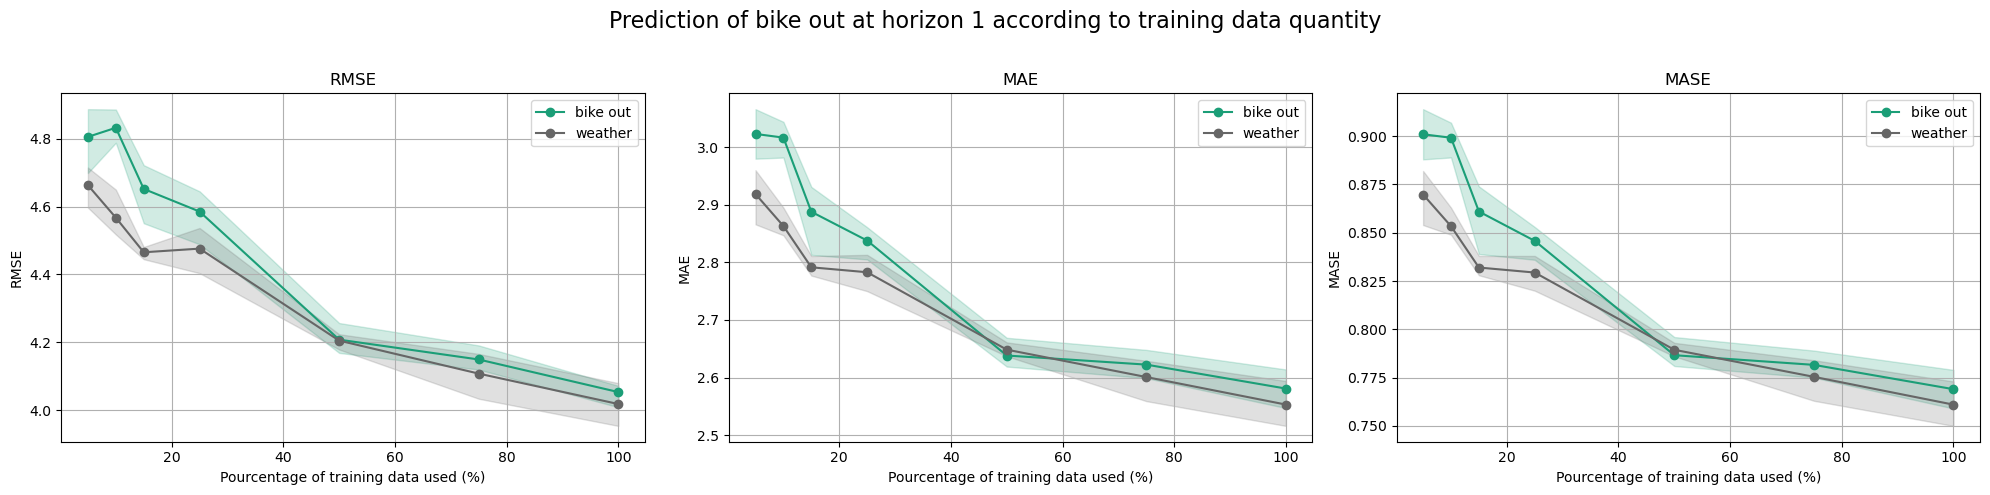

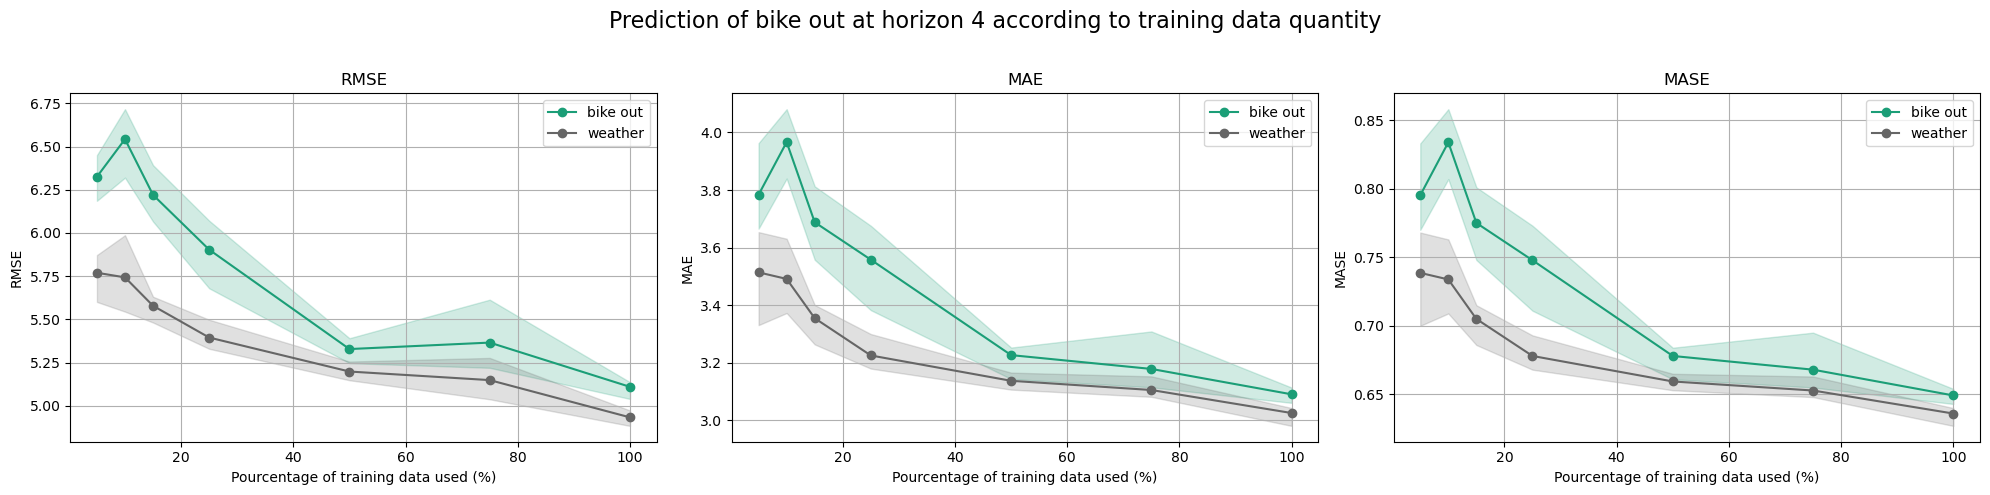

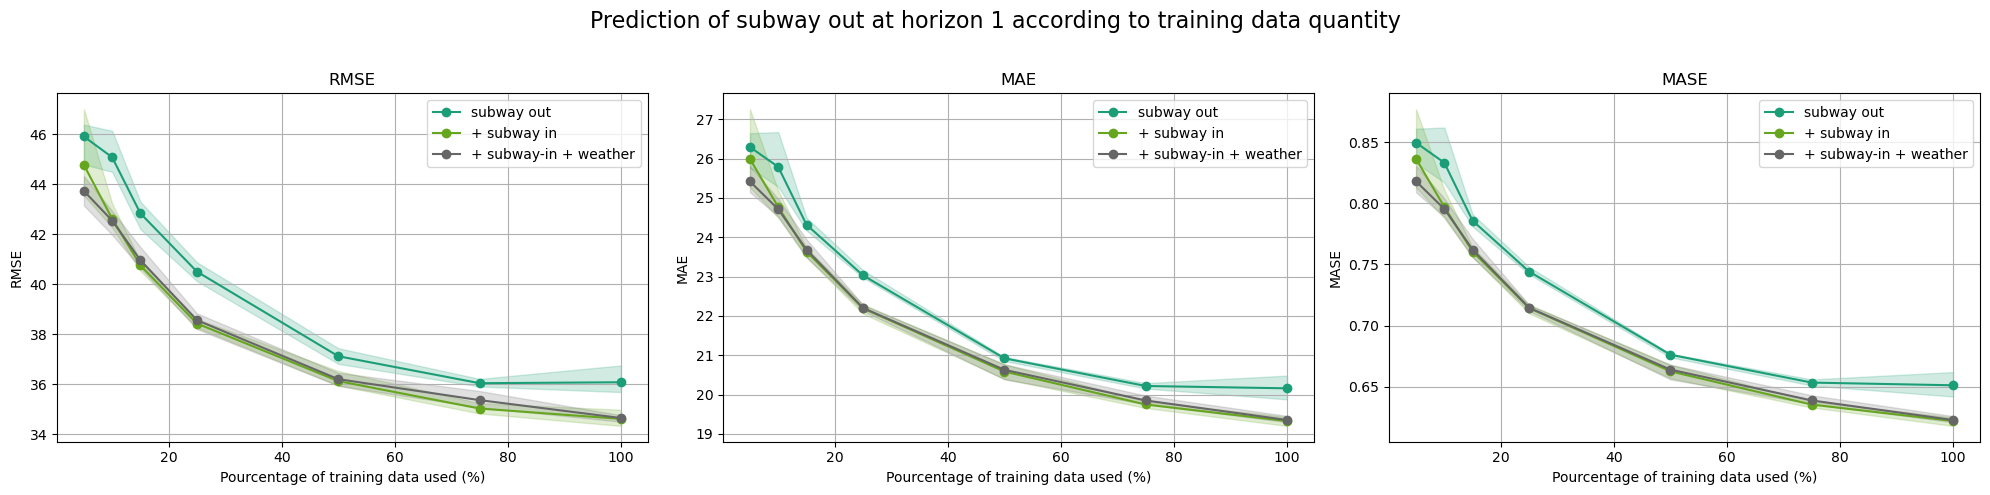

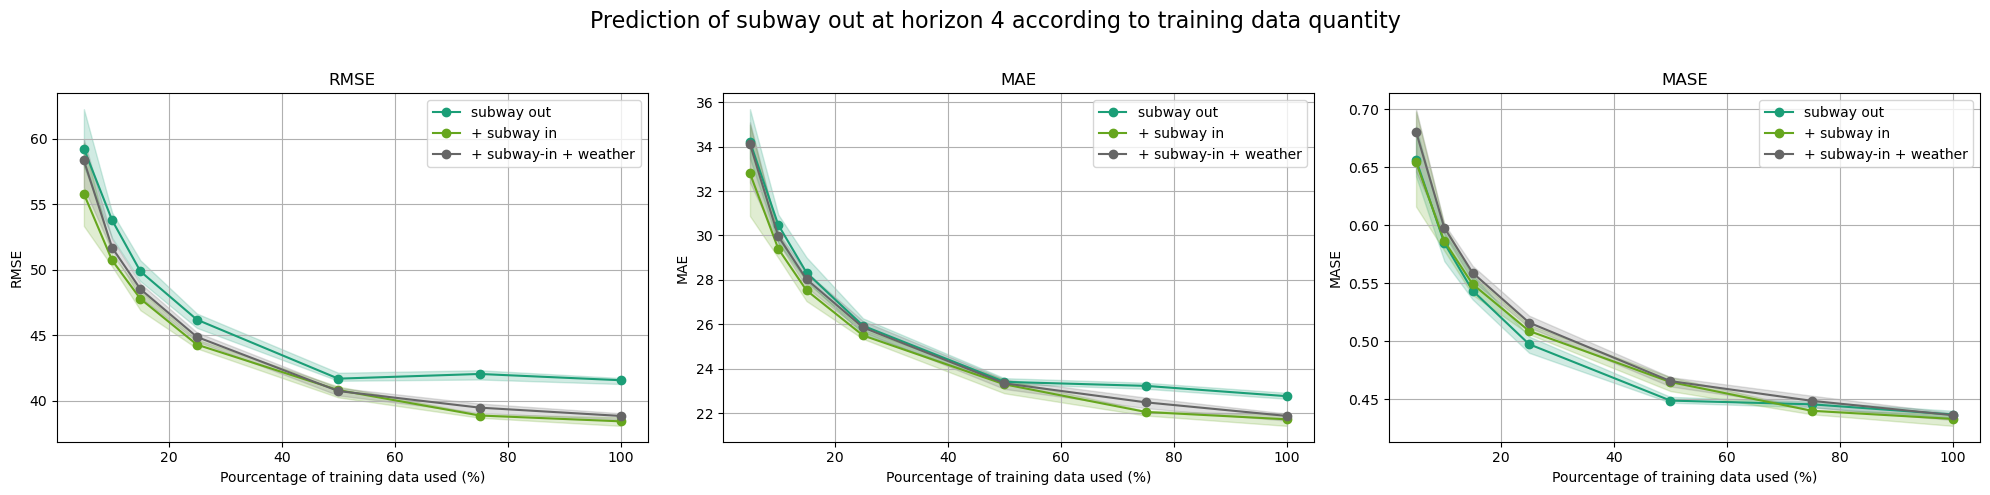

In [5]:
save_folder_path = None # 'save/plots' # 'experiences/contextual_data_integration/B_data_quantity/plots'

if False: 
    bike_out_configs = ['bike_out', 'bike_out_weather']
    plot_metrics(df[df['target'] == 'bike_out'], 'bike_out', bike_out_configs,save_folder_path,add_name = 'rainy_')

    subway_out_configs = ['subway_out', 'subway_out + subway in', 'subway_out + subway-in + weather']
    plot_metrics(df[df['target'] == 'subway_out'], 'subway_out', subway_out_configs,save_folder_path,add_name = 'rainy_')

if True:
    bike_out_configs = ['bike_out', 'bike_out_weather']
    plot_metrics(df[df['target'] == 'bike_out'], 'bike_out', bike_out_configs,save_folder_path, add_name = 'expanding_train_')

    subway_out_configs = ['subway_out', 'subway_out + subway in', 'subway_out + subway-in + weather']
    plot_metrics(df[df['target'] == 'subway_out'], 'subway_out', subway_out_configs,save_folder_path, add_name = 'expanding_train_')